In [1]:
# \实习一\实习一代码\city_nosie_analysis.py
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import DBSCAN
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import folium
from folium import Map, CircleMarker, FeatureGroup, LayerControl, Tooltip, TileLayer
from folium.plugins import HeatMap, MarkerCluster
import branca.colormap as cm
import matplotlib.colors as mcolors
from datetime import timedelta
from sklearn.neighbors import NearestNeighbors

## 数据预处理
- 将下载的一年的数据中提取十万条
    - 经过测试，一万条，十万条，五十万条发现十万条在数据结果与性能需求上最均衡，且十万条的结果与五十五条相差不大
- 数据清洗
    - 具体方法见`clean_noise_residential_data`注释
  


In [2]:
def clip_csv(input_csv_path:str,save_path:str,n:int=1000)->None:
    """从原始一年数据中提取前n条数据，保存为csv文件列"""
    df_top = pd.read_csv(
        input_csv_path,  
        nrows=n,            
        header=0               
    )
    df_top.to_csv(save_path, index=False)  
    print(f"已提取前{n}条数据，保存文件行数：{len(df_top)}行（1表头+{n}数据）")

def clean_noise_residential_data(input_csv_path: str) -> gpd.GeoDataFrame:
    """
    数据清洗：1、无经纬度坐标、无投诉创建时间的去除
    2、删除重复的unique key
    3、只选取投诉类型为Nosie-Residential
    4、只选取经纬度纬度 40.5°N - 41.0°N，经度 74.3°W - 73.7°W
    5、指定坐标系为EPSG:4326
    6、将create_data转换为datatime时间戳
    """
    # 读取数据
    df = pd.read_csv(input_csv_path)
    # 去除无经纬度和无投诉创建时间的数据
    df = df.dropna(subset=['Latitude', 'Longitude', 'Created Date'])
    # 删除重复的unique key
    if 'Unique Key' in df.columns:
        df = df.drop_duplicates(subset=['Unique Key'])
    # 只选取投诉类型为Noise-Residential
    if 'Complaint Type' in df.columns:
        df = df[df['Complaint Type'] == 'Noise - Residential']
    # 经纬度筛选
    df = df[(df['Latitude'] >= 40.5) & (df['Latitude'] <= 41.0) & 
            (df['Longitude'] >= -74.3) & (df['Longitude'] <= -73.7)]
    # 转换为GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
        crs="EPSG:4326"  # WGS84坐标系
    )
    # 转换时间戳
    gdf['Created Date'] = pd.to_datetime(gdf['Created Date'],format='%m/%d/%Y %I:%M:%S %p')
    gdf['Created Date'] = gdf['Created Date'].dt.tz_localize('America/New_York') # 设置为纽约时区
    
    print(f"清洗后数据条数：{len(gdf)}")
    return gdf

# 提取前1000条数据
original_csv_path=r"D:\必须用电脑解决的作业\地理大数据分析\实习一\实习一数据\311_Service_Requests_from_202311_to_202411_20250916.csv"
cliped_csv_path=r"D:\必须用电脑解决的作业\地理大数据分析\实习一\实习一数据\311_Service_Requests_from_202311_to_202411_top1000.csv"
clip_csv(original_csv_path,cliped_csv_path,n=100000)

# 数据清洗
gdf=clean_noise_residential_data(cliped_csv_path)

C:\Users\25345\AppData\Local\Temp\ipykernel_28600\4185862249.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_top = pd.read_csv(


已提取前100000条数据，保存文件行数：100000行（1表头+100000数据）


C:\Users\25345\AppData\Local\Temp\ipykernel_28600\4185862249.py:21: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv_path)


清洗后数据条数：11302


# 可视化调优DBSCAN参数
- 使用最小k距离值来确定eps，根据经验值选择k值，然后取k+1个值作为min_samples
- 通过绘图，手工选择拐点进行参数选择
- 此时的参数只作为参考，后续根据实际效果对参数进行微调

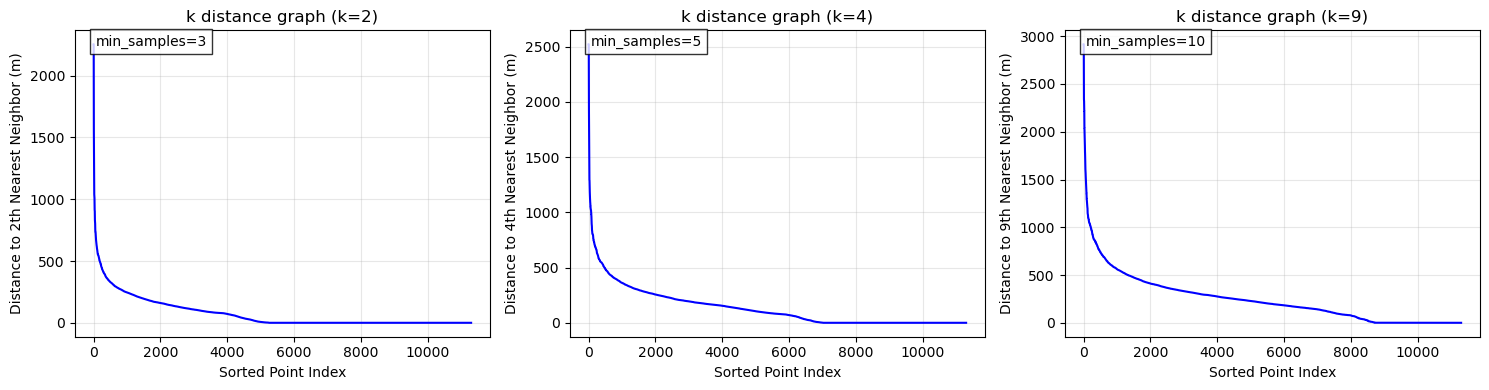

In [3]:
def visualize_dbscan_params(gdf: gpd.GeoDataFrame, min_samples_list: list=[3, 5, 10]) -> None:
    """
    为多个min_samples值可视化DBSCAN参数优化,用于手动选择eps值
    
    参数:
    gdf: GeoDataFrame, 包含经纬度信息
    min_samples_list: list, min_samples候选值列表
    
    返回:
    None
    """
    # 转换为投影坐标系
    gdf_proj = gdf.to_crs("EPSG:32618")
    coords = np.column_stack((gdf_proj.geometry.x, gdf_proj.geometry.y))
    
    # 计算子图布局
    n = len(min_samples_list)
    n_cols = min(3, n)  # 每行最多3个子图
    n_rows = (n + n_cols - 1) // n_cols
    
    # 创建图表
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # 为每个min_samples值绘制k距离图
    for i, min_samples in enumerate(min_samples_list):
        k = min_samples - 1
        
        # 计算k距离
        nn = NearestNeighbors(n_neighbors=k+1)  # +1 因为包含自身
        nn.fit(coords)
        distances, _ = nn.kneighbors(coords)
        k_distances = distances[:, -1]  # 第k个最近邻的距离
        
        # 对距离进行降序排序
        sorted_k_dist = np.sort(k_distances)[::-1]
        
        # 绘制k距离图
        ax = axes[i]
        ax.plot(np.arange(len(sorted_k_dist)), sorted_k_dist, 'b-', linewidth=1.5)
        
        # 设置标题和标签
        ax.set_title(f'k distance graph (k={k})')
        ax.set_xlabel('Sorted Point Index')
        ax.set_ylabel(f'Distance to {k}th Nearest Neighbor (m)')
        ax.grid(True, alpha=0.3)
        
        # 添加说明文本
        ax.text(0.05, 0.95, 
               f'min_samples={min_samples}', 
               transform=ax.transAxes, 
               fontsize=10,
               bbox=dict(facecolor='white', alpha=0.8))
    
    # 隐藏多余的子图
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

visualize_dbscan_params(gdf)


# 使用DBSCAN进行空间聚类分析
- 使用调优后的参数
- 绘制空间聚类结果
- gdf里增加一列culster存储聚类结果

聚类结果: 91个聚类, 294个噪声点


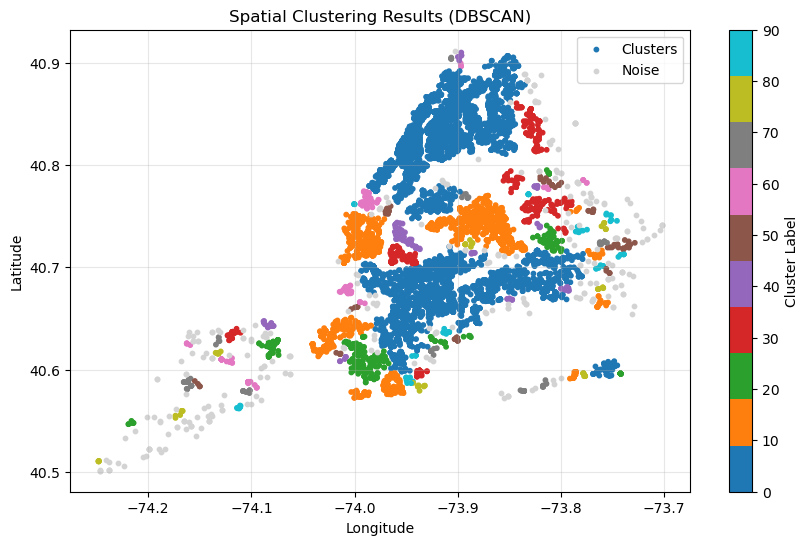

In [4]:
def spatial_clustering_analysis(gdf: gpd.GeoDataFrame, eps: float, min_samples: int) -> gpd.GeoDataFrame:
    """
    实现空间聚类分析，使用DBSCAN算法
    使用matplotlib库绘制空间聚类结果，使用投影坐标系EPSG:32618 (78°W-72°W)

    参数：
    gdf: GeoDataFrame, 包含经纬度信息
    eps: float, 邻域半径
    min_samples: int, 邻域内样本数阈值

    返回：
    gpd.GeoDataFrame: 原GeoDataFrame添加'cluster'列后返回，注意返回坐标系仍为地理坐标系EPSG:4326（WGS84）
    """ 
    # 转换为投影坐标系（EPSG:32618为UTM投影，单位是米，适合计算距离）
    gdf_proj = gdf.to_crs("EPSG:32618")
    
    # 修复坐标提取：从投影后的几何对象中获取x/y（而非用经纬度列名）
    coords = np.column_stack((gdf_proj.geometry.x, gdf_proj.geometry.y))
    
    # 执行DBSCAN聚类（基于投影坐标的米制距离）
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    gdf = gdf.copy()  # 避免修改原数据，创建副本
    gdf['cluster'] = db.labels_  # 添加聚类标签列
    
    # 统计聚类结果
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise = np.sum(db.labels_ == -1)
    print(f"聚类结果: {n_clusters}个聚类, {n_noise}个噪声点")

    # 优化可视化：添加颜色条、区分噪声、清晰配色
    plt.figure(figsize=(10, 6))
    # 分离聚类点和噪声点
    noise_mask = gdf['cluster'] == -1
    # 聚类点用分类色图，噪声点用灰色
    scatter = plt.scatter(
        gdf.geometry.x[~noise_mask], 
        gdf.geometry.y[~noise_mask], 
        c=gdf['cluster'][~noise_mask], 
        cmap='tab10',  # 分类配色更清晰
        s=10, 
        label='Clusters'
    )
    plt.scatter(
        gdf.geometry.x[noise_mask], 
        gdf.geometry.y[noise_mask], 
        c='lightgray', 
        s=10, 
        label='Noise'
    )
    plt.title("Spatial Clustering Results (DBSCAN)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(alpha=0.3)
    plt.colorbar(scatter, label='Cluster Label')  # 添加颜色条标签
    plt.legend()  # 显示图例
    plt.show()

    return gdf  

# (300,3)(355,5)(500,10)
gdf=spatial_clustering_analysis(gdf, eps=500, min_samples=5)

# 从时间角度进行噪声投诉分析
- 分别从每一天的时间段（几点）分析投诉量，绘制折线图，识别高峰
- 分别从每周的第几天（星期几）分析投诉量，绘制柱状图
- 受AI启发，每一天的时间是周期性的，但是在折线图中0点到24点距离很大，无法看出连续性，所以绘制了雷达图进行可视化
- 绘制热力图识别投诉的时间规律，尝试用dbscan算法进行自动聚类，但是效果并不好，因此最终只展示热力图，进行目视解释，聚类效果不好总结可能有以下原因：
   - 星期几是以七天为周期和一天中的时间是以24小时为周期，很难进行统一，导致距离计算存在问题
   - 时间是周期性，虽然星期一与星期天连续，但是距离的计算并非如此，尝试使用余弦函数进行统一，但是这样距离的尺度又进行了变化
   - 热力图的间隔问题很难表达边缘之间的连续关系（如周一和周日，0点和23点）



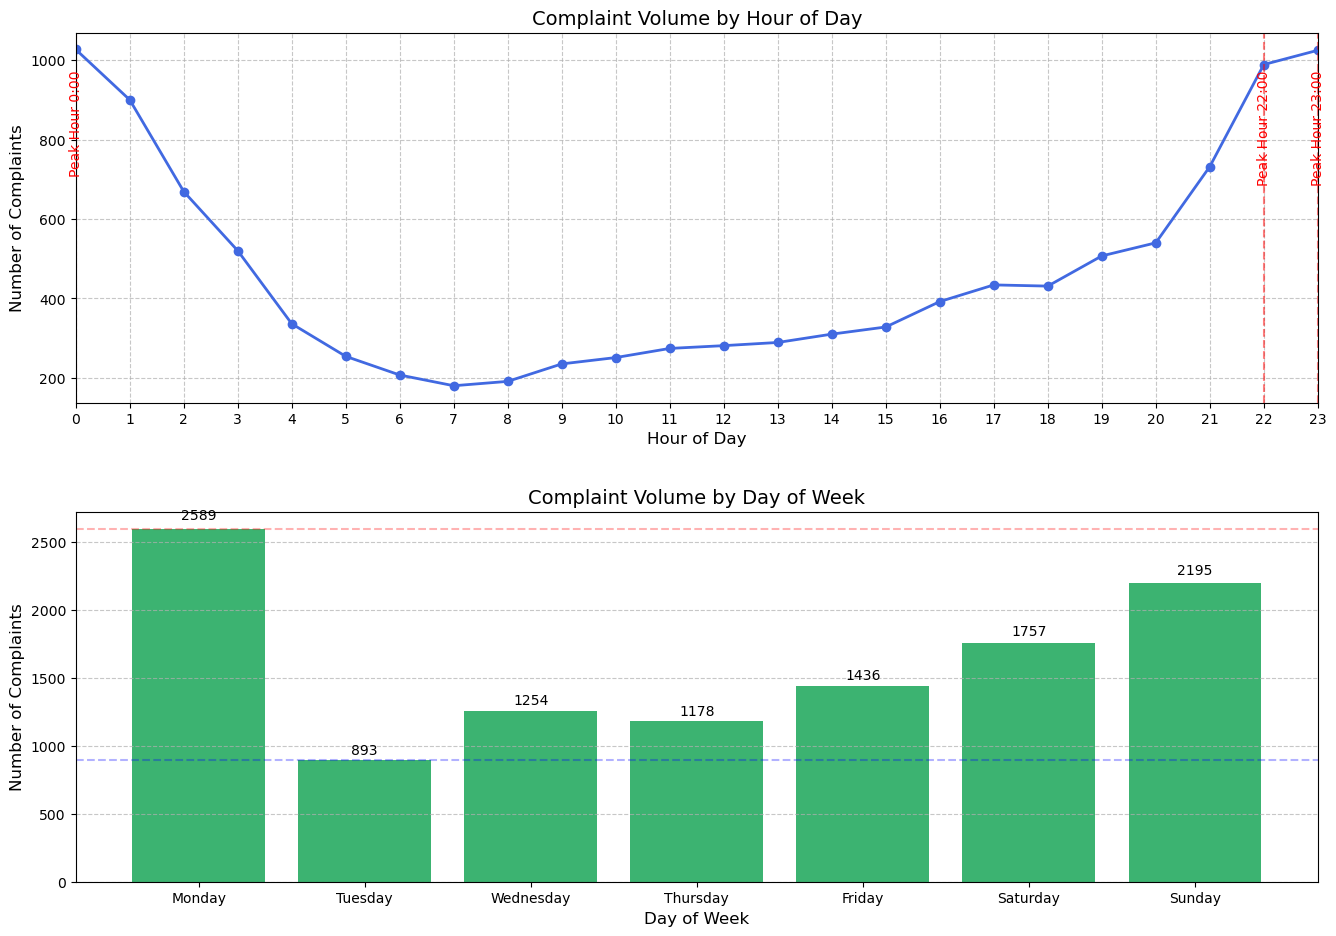

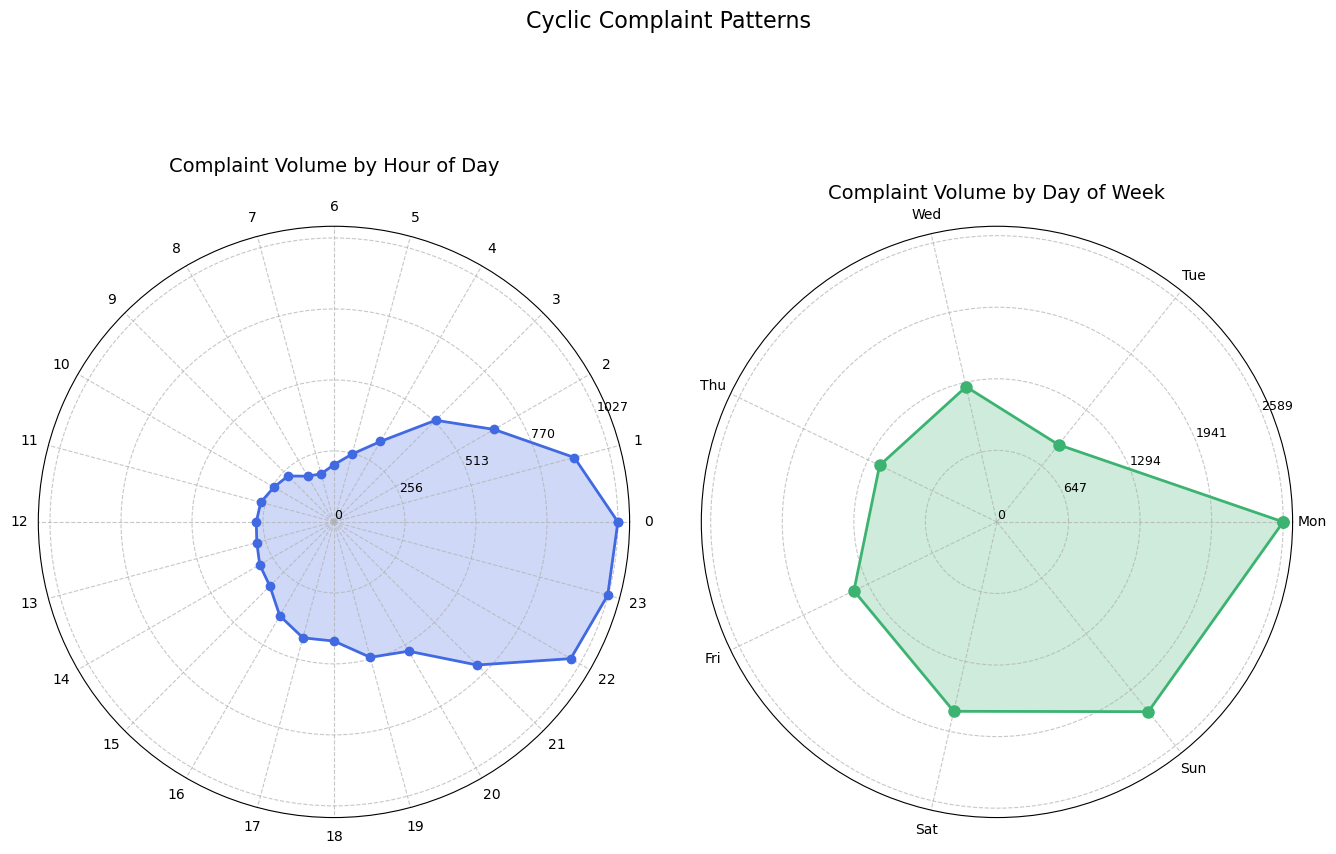

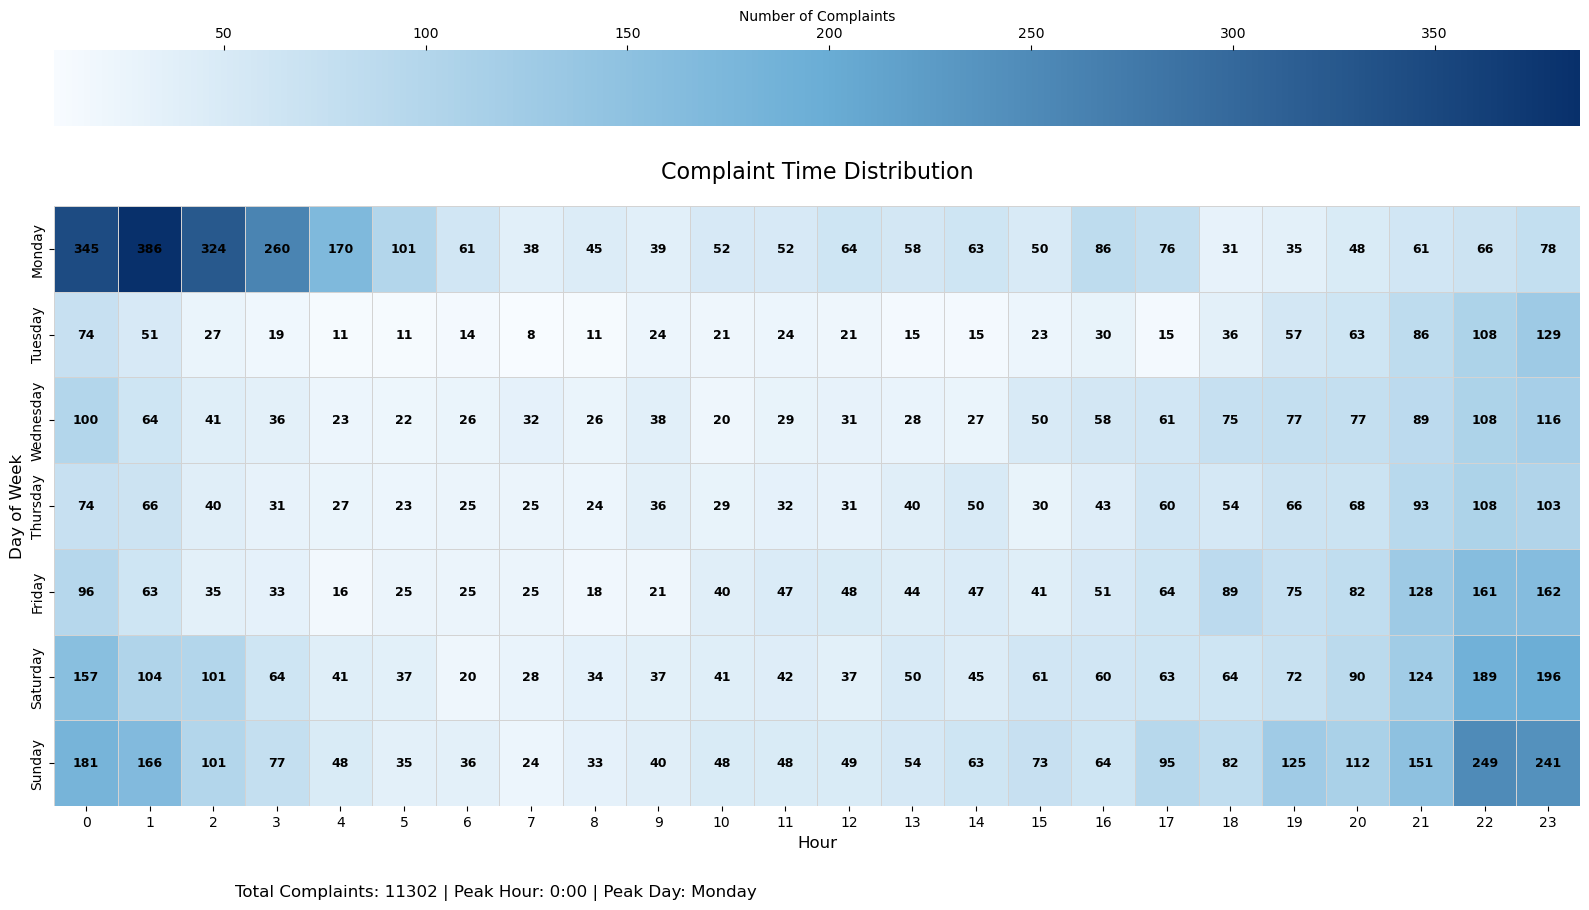

In [5]:
def plot_hourly_and_daily_complaint_patterns(gdf: gpd.GeoDataFrame) -> None:
    """
    绘制按小时和周几的投诉数量模式图
    
    参数:
    gdf: GeoDataFrame, 包含投诉数据
    """
    # 提取小时和周几信息
    gdf['hour'] = gdf['Created Date'].dt.hour
    gdf['day_of_week'] = gdf['Created Date'].dt.dayofweek  # Monday=0, Sunday=6
    
    # 创建图形
    plt.figure(figsize=(14, 10))
    
    # 1. 按小时投诉数量（折线图）
    plt.subplot(2, 1, 1)
    hourly_counts = gdf.groupby('hour').size()
    hourly_counts.plot(kind='line', marker='o', color='royalblue', linewidth=2)
    
    # 添加高峰时段标记
    peak_hours = hourly_counts.nlargest(3).index
    for hour in peak_hours:
        plt.axvline(x=hour, color='red', linestyle='--', alpha=0.5)
        plt.text(hour, hourly_counts.max() * 0.95, f'Peak Hour {hour}:00', 
                 rotation=90, ha='center', va='top', color='red')
    
    plt.title('Complaint Volume by Hour of Day', fontsize=14)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Number of Complaints', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(0, 24))
    plt.xlim(0, 23)
    
    # 2. 按周几投诉数量（柱状图）
    plt.subplot(2, 1, 2)
    daily_counts = gdf.groupby('day_of_week').size()
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # 使用柱状图展示每日投诉量
    bars = plt.bar(day_names, daily_counts, color='mediumseagreen')
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height*1.02,
                f'{height}', ha='center', va='bottom', fontsize=10)
    
    # 标记最高和最低日
    max_day = daily_counts.idxmax()
    min_day = daily_counts.idxmin()
    plt.axhline(y=daily_counts[max_day], color='red', linestyle='--', alpha=0.3)
    plt.axhline(y=daily_counts[min_day], color='blue', linestyle='--', alpha=0.3)
    
    plt.title('Complaint Volume by Day of Week', fontsize=14)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Number of Complaints', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # 调整布局
    plt.tight_layout(pad=3.0)
    plt.show()
    


def plot_cyclic_complaint_patterns(gdf: gpd.GeoDataFrame) -> dict:
    """
    使用雷达图展示周期性时间投诉模式
    
    参数:
    gdf: GeoDataFrame, 包含投诉数据
    
    返回:
    包含小时和每日统计数据的字典
    """
    # 确保'Created Date'是 datetime 类型
    if not pd.api.types.is_datetime64_any_dtype(gdf['Created Date']):
        gdf['Created Date'] = pd.to_datetime(gdf['Created Date'])
    
    # 提取小时和周几信息
    gdf['hour'] = gdf['Created Date'].dt.hour
    gdf['day_of_week'] = gdf['Created Date'].dt.dayofweek  # Monday=0, Sunday=6
    
    # 创建图形
    plt.figure(figsize=(14, 10))
    
    # 1. 按小时投诉数量（雷达图）
    ax1 = plt.subplot(1, 2, 1, polar=True)
    hourly_counts = gdf.groupby('hour').size()
    
    # 准备雷达图数据
    hours = np.arange(24)
    values = hourly_counts.reindex(hours, fill_value=0).values
    
    # 创建角度（24小时）
    angles = np.linspace(0, 2*np.pi, 24, endpoint=False)  # 24个点，不闭合
    
    # 闭合曲线（首尾相连）
    values = np.append(values, values[0])
    angles = np.append(angles, angles[0])
    
    # 绘制雷达图
    ax1.plot(angles, values, 'o-', linewidth=2, color='royalblue', markersize=6)
    ax1.fill(angles, values, color='royalblue', alpha=0.25)
    
    # 设置极坐标标签（使用24小时，不重复最后一个）
    ax1.set_xticks(angles[:-1])  # 使用除最后一个外的所有角度
    ax1.set_xticklabels(hours)    # 24个小时标签
    
    ax1.set_yticks(np.linspace(0, hourly_counts.max(), 5))
    ax1.set_yticklabels([f'{int(x)}' for x in np.linspace(0, hourly_counts.max(), 5)], fontsize=9)
    
    # 添加标题和网格
    ax1.set_title('Complaint Volume by Hour of Day', fontsize=14, pad=20)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. 按周几投诉数量（雷达图）
    ax2 = plt.subplot(1, 2, 2, polar=True)
    daily_counts = gdf.groupby('day_of_week').size()
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    # 准备雷达图数据
    days = np.arange(7)
    values = daily_counts.reindex(days, fill_value=0).values
    
    # 创建角度（7天）
    angles = np.linspace(0, 2*np.pi, 7, endpoint=False)  # 7个点，不闭合
    
    # 闭合曲线（首尾相连）
    values = np.append(values, values[0])
    angles = np.append(angles, angles[0])
    
    # 绘制雷达图
    ax2.plot(angles, values, 'o-', linewidth=2, color='mediumseagreen', markersize=8)
    ax2.fill(angles, values, color='mediumseagreen', alpha=0.25)
    
    # 设置极坐标标签
    ax2.set_xticks(angles[:-1])  # 使用除最后一个外的所有角度
    ax2.set_xticklabels(day_names)  # 7个星期标签
    
    ax2.set_yticks(np.linspace(0, daily_counts.max(), 5))
    ax2.set_yticklabels([f'{int(x)}' for x in np.linspace(0, daily_counts.max(), 5)], fontsize=9)
    
    # 添加标题和网格
    ax2.set_title('Complaint Volume by Day of Week', fontsize=14, pad=20)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 添加整体标题
    plt.suptitle('Cyclic Complaint Patterns', fontsize=16, y=0.98)
    
    # 调整布局
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # 返回统计数据
    return {
        'hourly_counts': hourly_counts,
        'daily_counts': daily_counts
    }

def visualize_hourly_complaint_distribution(gdf: gpd.GeoDataFrame):
    """
    可视化投诉时间分布热力图，显示具体数值
    
    参数:
    gdf: GeoDataFrame, 包含投诉数据（时区已由您处理）
    """
    # 提取小时和星期几信息
    gdf['hour'] = gdf['Created Date'].dt.hour
    gdf['day_of_week'] = gdf['Created Date'].dt.dayofweek  # Monday=0, Sunday=6
    
    # 创建热力图数据
    heatmap_data = gdf.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
    
    # 创建热力图
    plt.figure(figsize=(16, 10))
    
    # 使用更清晰的热力图颜色
    heatmap_cmap = LinearSegmentedColormap.from_list('heatmap_cmap', ['#f7fbff', '#6baed6', '#08306b'])
    
    # 绘制热力图并显示数值
    ax = sns.heatmap(
        heatmap_data, 
        cmap=heatmap_cmap,
        annot=True,  # 显示数值
        fmt="d",    # 整数格式
        annot_kws={"size": 9, "color": "black", "weight": "bold"},  # 数值格式
        cbar_kws={'label': 'Number of Complaints', 'location': 'top', 'pad': 0.1},
        linewidths=0.5,
        linecolor='lightgray'
    )
    
    # 移动颜色条到顶部避免重叠
    cbar = ax.collections[0].colorbar
    cbar.ax.set_position([0.15, 1.02, 0.7, 0.03])  # [left, bottom, width, height]
    cbar.ax.xaxis.set_ticks_position('top')
    
    # 设置坐标轴标签
    plt.title("Complaint Time Distribution", fontsize=16, pad=20)
    plt.xlabel("Hour", fontsize=12)
    plt.ylabel("Day of Week", fontsize=12)

    # 设置星期几标签
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    plt.yticks(np.arange(7) + 0.5, day_names, fontsize=10)
    
    # 设置小时标签
    plt.xticks(np.arange(24) + 0.5, range(24), fontsize=10)
    
    # 添加时间分布统计
    total_complaints = heatmap_data.values.sum()
    max_hour = heatmap_data.sum(axis=0).idxmax()
    max_day = heatmap_data.sum(axis=1).idxmax()
    
    plt.figtext(0.15, 0.01, 
               f"Total Complaints: {total_complaints} | Peak Hour: {max_hour}:00 | Peak Day: {day_names[max_day]}",
               fontsize=12, ha="left")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.1)  # 为顶部颜色条和底部文本留出空间
    plt.show()
    
    # return heatmap_data

# 按小时投诉数量进行绘图
plot_hourly_and_daily_complaint_patterns(gdf)
# 绘制雷达图
plot_cyclic_complaint_patterns(gdf)
# 绘制热力图
visualize_hourly_complaint_distribution(gdf)

# 制作folium地图
对于地图的制作，我在生成的html里增加了以下几个小巧思：
- 考虑到底图的配色会影响地图的美观性，以及地图的可读性，支持调节底图（`亮色`、`暗色`），在右侧的按钮就可以调节
- 将热力图、点数、噪声点、聚类类别分别放在三个图层里，用户可以很方便的选择图层组合并查看（相比于默认每一类别一个图层导致十几个图层，这种方案更具操作性）
- 考虑点的可读性，适当增强点颜色的对比度，当鼠标悬浮在点上面可以看到点所属于的类别，以及类别里点的个数
- 在左侧添加了一个**面板**，同时可以隐藏，里面记录了基本的统计数据，同时使用echart绘制了一些图表（具体实现在`stat_html.py`里，下面函数进行调用）

受jyputer限制无法总结显示地图，请打开附件中的html文件查看

In [7]:
from stat_html import *
from folium import Map, TileLayer, FeatureGroup, LayerControl, CircleMarker, Tooltip
from folium.plugins import HeatMap, MarkerCluster
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from branca.element import Element

def create_folium_map(
    gdf: gpd.GeoDataFrame,
    map_style: str = "light"
) -> None:
    """创建优化后的噪声聚类地图"""
    # 底图模式选择
    tile_options = {
        "light": "CartoDB positron",
        "dark": "CartoDB dark_matter"
    }
    if map_style not in tile_options:
        raise ValueError("map_style仅支持'light'或'dark'")

    # 初始化地图
    center_lat = gdf.geometry.y.mean()
    center_lon = gdf.geometry.x.mean()
    m = Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles=None
    )

    # 添加可切换底图
    TileLayer(
        tiles=tile_options["light"],
        name="白色底图",
        control=True
    ).add_to(m)
    TileLayer(
        tiles=tile_options["dark"],
        name="黑色底图",
        control=True
    ).add_to(m)

    # 热图图层
    heat_data = [[point.y, point.x] for point in gdf.geometry]
    heat_layer = FeatureGroup(name='投诉密度热图', show=True)
    HeatMap(
        heat_data,
        name='投诉密度',
        radius=15,
        blur=10,
        min_opacity=0.3,
        gradient={0.0: 'blue', 0.2: 'cyan', 0.4: 'yellow', 0.6: 'orange', 1.0: 'red'}
    ).add_to(heat_layer)
    heat_layer.add_to(m)

    # 聚类配色
    valid_clusters = gdf[gdf['cluster'] != -1]['cluster'].unique()
    valid_clusters = sorted(valid_clusters)

    # 计算每个聚类的点数量
    cluster_counts = {}
    for cluster_id in valid_clusters:
        cluster_counts[cluster_id] = gdf[gdf['cluster'] == cluster_id].shape[0]

    # 高区分度颜色库 - 使用与热力图区分度高的颜色方案
    try:
        # 使用Set3调色板，提供12种高区分度颜色
        if len(valid_clusters) <= 12:
            cmap = plt.colormaps['Set3'].resample(len(valid_clusters))
            color_palette = [mcolors.to_hex(cmap(i)) for i in range(len(valid_clusters))]
        else:
            # 对于超过12个聚类的情况，使用tab20调色板
            if len(valid_clusters) <= 20:
                cmap = plt.colormaps['tab20'].resample(len(valid_clusters))
                color_palette = [mcolors.to_hex(cmap(i)) for i in range(len(valid_clusters))]
            else:
                # 对于超过20个聚类的情况，循环使用Set3颜色
                base_cmap = plt.colormaps['Set3'].resample(12)
                color_palette = [mcolors.to_hex(base_cmap(i % 12)) for i in range(len(valid_clusters))]
    except:
        base_colors = ['#4B0082', '#008000', '#FF00FF', '#800000', '#00FF00', 
                      '#000080', '#FF0000', '#808000', '#00FFFF', '#FFA500']
        if len(valid_clusters) > len(base_colors):
            color_palette = base_colors * (len(valid_clusters) // len(base_colors) + 1)
        else:
            color_palette = base_colors[:len(valid_clusters)]

    # 创建颜色映射字典
    cluster_color_map = {}
    for i, cluster_id in enumerate(valid_clusters):
        cluster_color_map[cluster_id] = color_palette[i]

    # 噪声点图层 - 降低显眼度改进
    noise_points = gdf[gdf['cluster'] == -1]
    noise_count = noise_points.shape[0] if not noise_points.empty else 0
    
    if not noise_points.empty:
        noise_layer = FeatureGroup(name='噪声点 (未聚类)', show=True)
        for _, row in noise_points.iterrows():
            CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=2,  # 减小半径
                color='#888888',  # 使用更中性的灰色
                fill=True,
                fill_color='#888888',
                fill_opacity=0.4,  # 降低填充透明度
                weight=1,  # 减小边框粗细
                tooltip=Tooltip(f"噪声点 (未聚类), 数量: {noise_count}")
            ).add_to(noise_layer)
        noise_layer.add_to(m)

    # 所有聚类点归为一个图层 - 新增功能
    all_clusters_layer = FeatureGroup(name='点数统计', show=True)
    marker_cluster = MarkerCluster().add_to(all_clusters_layer)
    
    for cluster_id in valid_clusters:
        cluster_points = gdf[gdf['cluster'] == cluster_id]
        cluster_color = cluster_color_map[cluster_id]
        
        for _, row in cluster_points.iterrows():
            CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=4,
                color=cluster_color,
                fill=True,
                fill_color=cluster_color,
                fill_opacity=0.8,
                tooltip=Tooltip(f"聚类ID: {cluster_id}, 点数量: {cluster_counts[cluster_id]}")
            ).add_to(marker_cluster)
    
    all_clusters_layer.add_to(m)

    # 所有点综合显示图层（按类别着色） - 移除未聚类点
    all_points_layer = FeatureGroup(name='所有点（按类别着色）', show=True)
    
    for _, row in gdf.iterrows():
        # 跳过未聚类点（cluster == -1）
        if row['cluster'] == -1:
            continue
            
        color = cluster_color_map[row['cluster']]
        fill_opacity = 0.8
        radius = 4
        tooltip_text = f"聚类ID: {row['cluster']}, 点数量: {cluster_counts[row['cluster']]}"
        
        CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=radius,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=fill_opacity,
            tooltip=Tooltip(tooltip_text)
        ).add_to(all_points_layer)
    
    all_points_layer.add_to(m)

    # 计算基本统计数据
    total_points = len(gdf)
    clustered_count = total_points - noise_count
    clustered_percentage = (clustered_count / total_points * 100) if total_points > 0 else 0
    
    # 计算聚类分布
    cluster_distribution = []
    for cluster_id in valid_clusters:
        count = cluster_counts[cluster_id]
        percentage = (count / clustered_count * 100) if clustered_count > 0 else 0
        cluster_distribution.append({
            'id': cluster_id,
            'count': count,
            'percentage': percentage
        })
    
    # 按数量排序聚类分布
    cluster_distribution.sort(key=lambda x: x['count'], reverse=True)
    
    # 生成统计信息HTML（侧拉面板）
    html_content = generate_stats_html(gdf, noise_count, valid_clusters, cluster_counts)
    # with open("stats_panel.html", "w", encoding="utf-8") as f:
    #     f.write(html_content)
    stats_element = Element(html_content)
    # 图层控制器
    LayerControl(position='topright', collapsed=False).add_to(m)
    # 将统计信息添加到地图
    m.get_root().html.add_child(stats_element)

    # 保存地图
    map_filename = f'noise_clusters_{map_style}.html'
    m.save(map_filename)
    print(f"地图已保存为: {map_filename}")

# 创建folium地图
create_folium_map(gdf)


地图已保存为: noise_clusters_light.html


# 拓展：识别高密度的投诉量并尝试在互联网中查找原因

这里的目的是希望从现有的数据中挖掘出纽约市的大事件，并通过网上的资料进行验证。具体方法是通过计算每个小时里的投诉量，并找到投诉量大于均值加两倍标准差的时间段作为异常值，后续查看是否有连续的异常值，如果两个异常值相隔不到一个小时则进行合并，最后找到投诉量最高的5个时间段。
通过设计提示词，利用Grok AI 能够自动查找国外大型社交平台X及互联网数据的能力，让其分析原因，并找到可能的大事件。

神奇的是算法自动识别出了元旦和圣诞节两个重大节日。

In [ ]:
def find_high_density_periods(gdf: gpd.GeoDataFrame) -> None:
    """
    识别高密度投诉的时间段并打印结果
    
    参数:
    gdf: GeoDataFrame, 包含投诉数据
    """
    # 确保时间列是datetime类型
    if not pd.api.types.is_datetime64_any_dtype(gdf['Created Date']):
        gdf['Created Date'] = pd.to_datetime(gdf['Created Date'], format='%m/%d/%Y %I:%M:%S %p')
    
    # 创建时间序列索引
    time_series = gdf.set_index('Created Date').sort_index()
    
    # 使用计算每小时投诉数量
    rolling_counts = time_series.groupby(pd.Grouper(freq='1h')).size().dropna()
    
    # 计算统计阈值
    mean_count = rolling_counts.mean()
    std_dev = rolling_counts.std()
    # 识别两倍标准差外的异常值，同时做容错处理
    if pd.isna(std_dev) or std_dev == 0:
        print("警告: 数据不足或标准差为零")
        return
    high_density_threshold = mean_count + 2 * std_dev
    
    # 找到所有超过阈值的时间点
    high_density_points = rolling_counts[rolling_counts > high_density_threshold]
    
    if high_density_points.empty:
        print("没有找到显著的高密度投诉时段")
        # 打印最密集的5个时间段
        top_periods = rolling_counts.sort_values(ascending=False).head(5)
        print("\n投诉量最高的5个时间段:")
        for time, count in top_periods.items():
            start_time = time
            end_time = time + timedelta(hours=1)
            print(f"  {start_time.strftime('%Y-%m-%d %H:%M')} - {end_time.strftime('%H:%M')}: {count} 起投诉")
        return
    
    # 找出连续的高峰时段
    high_density_df = high_density_points.reset_index()
    high_density_df.columns = ['start_time', 'count']
    high_density_df['end_time'] = high_density_df['start_time'] + timedelta(hours=1)
    high_density_df['time_diff'] = high_density_df['start_time'].diff().dt.total_seconds() / 60
    high_density_df['group'] = (high_density_df['time_diff'] > 60).cumsum()  # 60分钟间隔
    
    # 分组并找出高峰时段
    peak_groups = high_density_df.groupby('group').agg(
        start_time=('start_time', 'min'),
        end_time=('end_time', 'max'),
        max_count=('count', 'max'),
        avg_count=('count', 'mean')
    )
    
    # 计算持续时间
    peak_groups['duration'] = (peak_groups['end_time'] - peak_groups['start_time']).dt.total_seconds() / 60
    
    # 按最大投诉量排序
    peak_groups = peak_groups.sort_values('max_count', ascending=False)
    
    # 打印结果
    print("="*80)
    print("高密度投诉时段分析结果")
    print("="*80)
    
    num=0
    for i, (_, row) in enumerate(peak_groups.iterrows()):
        num+=1
        if num>3:
            break
        print(f"\n高峰时段 {i+1}:")
        print(f"  开始时间: {row['start_time'].strftime('%Y-%m-%d %H:%M')}")
        print(f"  结束时间: {row['end_time'].strftime('%Y-%m-%d %H:%M')}")
        print(f"  持续时间: {int(row['duration'])} 分钟")
        print(f"  最高投诉量: {int(row['max_count'])}")
        print(f"  平均投诉量: {row['avg_count']:.1f}")
        
        # 获取该时间段内的投诉数据
        period_df = gdf[(gdf['Created Date'] >= row['start_time']) & 
                        (gdf['Created Date'] <= row['end_time'])]
        
        # 打印地点分布
        if 'Borough' in period_df.columns:
            borough_counts = period_df['Borough'].value_counts().head(3)
            print("\n  行政区分布:")
            for borough, count in borough_counts.items():
                print(f"    {borough}: {count} 起投诉")
        
        if 'City' in period_df.columns:
            city_counts = period_df['City'].value_counts().head(3)
            print("\n  城市分布:")
            for city, count in city_counts.items():
                print(f"    {city}: {count} 起投诉")
        
        if 'Incident Address' in period_df.columns:
            address_counts = period_df['Incident Address'].value_counts().head(3)
            print("\n  地址分布:")
            for address, count in address_counts.items():
                print(f"    {address}: {count} 起投诉")
        
        # 打印投诉类型分布
        if 'Descriptor' in period_df.columns:
            descriptor_counts = period_df['Descriptor'].value_counts().head(3)
            print("\n  投诉描述分布:")
            for desc, count in descriptor_counts.items():
                print(f"    {desc}: {count} 起投诉")
        
        print("-"*60)
    
    print("="*80)

find_high_density_periods(gdf)


高密度投诉时段分析结果

高峰时段 1:
  开始时间: 2023-12-31 22:00
  结束时间: 2024-01-01 04:00
  持续时间: 360 分钟
  最高投诉量: 218
  平均投诉量: 152.5

  行政区分布:
    QUEENS: 267 起投诉
    BROOKLYN: 249 起投诉
    BRONX: 182 起投诉

  城市分布:
    BROOKLYN: 249 起投诉
    NEW YORK: 182 起投诉
    BRONX: 179 起投诉

  地址分布:
    640 STANLEY AVENUE: 17 起投诉
    233 LANDING ROAD: 12 起投诉
    1465 WASHINGTON AVENUE: 9 起投诉

  投诉描述分布:
    Loud Music/Party: 755 起投诉
    Banging/Pounding: 135 起投诉
    Loud Talking: 24 起投诉
------------------------------------------------------------

高峰时段 2:
  开始时间: 2023-12-24 22:00
  结束时间: 2023-12-25 04:00
  持续时间: 360 分钟
  最高投诉量: 185
  平均投诉量: 148.3

  行政区分布:
    QUEENS: 316 起投诉
    BRONX: 211 起投诉
    BROOKLYN: 183 起投诉

  城市分布:
    BRONX: 210 起投诉
    BROOKLYN: 182 起投诉
    NEW YORK: 150 起投诉

  地址分布:
    117-23 147 STREET: 16 起投诉
    2120 MAPES AVENUE: 9 起投诉
    1755 WEEKS AVENUE: 8 起投诉

  投诉描述分布:
    Loud Music/Party: 755 起投诉
    Banging/Pounding: 109 起投诉
    Loud Talking: 20 起投诉
---------------------------------------------